# Task
Our task is simple, recognize handwritten digits. We will use MNIST dataset for this tutorial.


# Import necessary library
In this tutorial, we are going to use pytorch, the cutting-edge deep learning framework to complete our task.

In [10]:
import torch
import torchvision

In [11]:
import sys
print("Python版本信息:")
print(sys.version)

import torch
print("torch版本信息:")
print(torch.__version__)

import sys
print("python路径:")
print(sys.executable)

Python版本信息:
3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
torch版本信息:
1.14.0a0+44dac51
python路径:
/usr/bin/python


In [12]:
## Create dataloader, in PyTorch, we feed the trainer data with use of dataloader
## We create dataloader with dataset from torchvision, 
## and we dont have to download it seperately, all automatically done

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

Label: tensor(8)


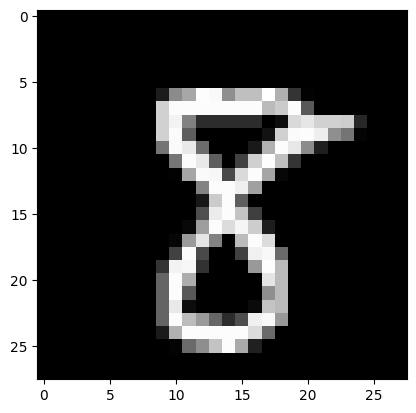

In [13]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

In [14]:
## Now we can start to build our CNN model
## We first import the pytorch nn module and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## Then define the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, -1)

In [15]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
device = "cpu"
model = CNN().to(device) #using cpu here
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [16]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
print("Start training ...")
num_epoch = 3
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        
print("Done")

Start training ...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296268
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.914678
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.078843
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.855374
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.808118
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.708180
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.773150
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.371319
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.490064
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.436969

Test set: Average loss: 0.3583, Accuracy: 8944/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.462343
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.460069
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.515179
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.409296
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.656205
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.485283
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.373111
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.328676
Train Epoch: 2 [51200/60000 (85%

In [18]:
# from torchsummary import summary
# summary(model, (1, 28, 28))